# Neural Networks
In this notebook we will learn how to train a simple Multilayer Perceptron for image classification using PyTorch. You can find additional information [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Load dataset

In [3]:
# torchvision has some datasets already included, so we will load MNIST through torchvision
# first we need to define the transformations

data_aug = transforms.Compose([transforms.ToTensor()]) # the ToTensor transform scales the image into [0., 1.0] range
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
indices = list(range(len(validation_data)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

torch.Size([1, 28, 28])
5
torch.Size([64, 1, 28, 28])
tensor([9, 3, 9, 5, 2, 1, 8, 1, 1, 9, 5, 8, 0, 0, 5, 8, 0, 9, 7, 1, 3, 5, 6, 0,
        9, 3, 9, 4, 2, 3, 0, 2, 4, 3, 9, 7, 3, 4, 6, 4, 5, 7, 1, 5, 4, 5, 5, 9,
        7, 5, 3, 6, 7, 3, 1, 1, 3, 4, 0, 8, 3, 2, 8, 9])


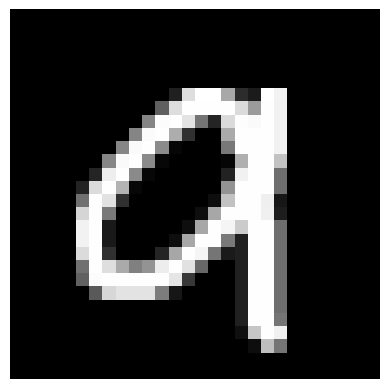

In [10]:
# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

# let's visualize the data
# alternative 1: using the Dataset
sample = training_data[0] 
img = sample[0]
label = sample[1]
print(img.shape) # note that here we only get one image and its label
print(label)

# alternative 2: iterate over the Dataloader
for batch in train_dataloader:
  imgs = batch[0]
  labels = batch[1]
  print(imgs.shape)
  print(labels)

  plt.imshow(imgs[0][0,:,:], cmap='gray')
  plt.axis('off')
  plt.show()
  break

## Defining the model

Create an MLP with the following structure: 

1. Dense/linear layer that takes the images as a flattened input vector and generates an output of 512 of dimension.
2. ReLU activation layer
3. Dense/linear layer with 512 input and output
3. ReLU activation layer
4. Dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        

    def forward(self, x):
        x = self.flatten(x)
        layers = self.linear_relu(x)
        return layers
         

model = NeuralNetwork().to(device) # put model in device (GPU or CPU)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Interpret the implemented architecture and try to answer the following questions:

a) What is the shape (width, and # of channels) of the output tensor after the first layer?

b) And after the first 3 layers (dense+dense+dense)?

c) How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://pypi.org/project/torch-summary/)

In [14]:
#!pip install torch-summary

from torchsummary import summary

summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 512]                 262,656
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 10]                  5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 512]                 401,920
|    └─ReLU: 2-2                         [-1, 512]                 --
|    └─Linear: 2-3                       [-1, 512]                 262,656
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 10]                  5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
Total mult-adds (M): 1.34
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57

## Train the model

Define:
1. The loss function
2. The optimiser 
3. The training loop

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,)

In [18]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # TODO: Compute final prediction (softmax + argmax)
          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [19]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:07<00:00, 125.01it/s]


Train loss: 1.570 	 Train acc: 0.646


100%|██████████| 125/125 [00:00<00:00, 161.28it/s]


Val loss: 0.664 	 Val acc: 0.837

Epoch 2


100%|██████████| 937/937 [00:06<00:00, 138.84it/s]


Train loss: 0.503 	 Train acc: 0.867


100%|██████████| 125/125 [00:00<00:00, 174.76it/s]


Val loss: 0.398 	 Val acc: 0.889

Epoch 3


100%|██████████| 937/937 [00:05<00:00, 161.52it/s]


Train loss: 0.375 	 Train acc: 0.895


100%|██████████| 125/125 [00:00<00:00, 143.78it/s]


Val loss: 0.340 	 Val acc: 0.903

Epoch 4


100%|██████████| 937/937 [00:06<00:00, 150.93it/s]


Train loss: 0.329 	 Train acc: 0.906


100%|██████████| 125/125 [00:00<00:00, 148.08it/s]


Val loss: 0.304 	 Val acc: 0.911

Epoch 5


100%|██████████| 937/937 [00:07<00:00, 130.92it/s]


Train loss: 0.301 	 Train acc: 0.914


100%|██████████| 125/125 [00:00<00:00, 152.34it/s]


Val loss: 0.285 	 Val acc: 0.919

Epoch 6


100%|██████████| 937/937 [00:07<00:00, 131.89it/s]


Train loss: 0.278 	 Train acc: 0.921


100%|██████████| 125/125 [00:00<00:00, 140.99it/s]


Val loss: 0.262 	 Val acc: 0.927

Epoch 7


100%|██████████| 937/937 [00:07<00:00, 132.72it/s]


Train loss: 0.258 	 Train acc: 0.927


100%|██████████| 125/125 [00:00<00:00, 147.14it/s]


Val loss: 0.250 	 Val acc: 0.929

Epoch 8


100%|██████████| 937/937 [00:07<00:00, 130.22it/s]


Train loss: 0.241 	 Train acc: 0.931


100%|██████████| 125/125 [00:00<00:00, 137.13it/s]


Val loss: 0.231 	 Val acc: 0.936

Epoch 9


100%|██████████| 937/937 [00:06<00:00, 134.16it/s]


Train loss: 0.225 	 Train acc: 0.936


100%|██████████| 125/125 [00:00<00:00, 151.38it/s]


Val loss: 0.216 	 Val acc: 0.939

Epoch 10


100%|██████████| 937/937 [00:07<00:00, 131.63it/s]


Train loss: 0.211 	 Train acc: 0.941


100%|██████████| 125/125 [00:00<00:00, 147.95it/s]

Val loss: 0.203 	 Val acc: 0.942
Finished


## Analyse training evolution

In [20]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

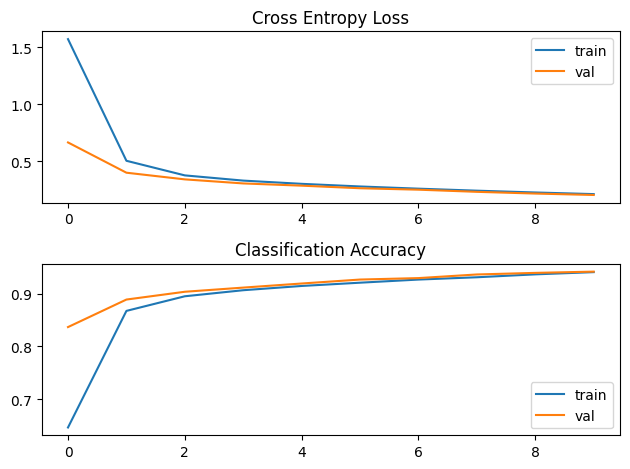

In [21]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set.

In [22]:
test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"Test loss: {test_loss:.3f} \t Test acc: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:03<00:00, 591.44it/s]

Test loss: 0.190 	 Test acc: 0.943


In [23]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

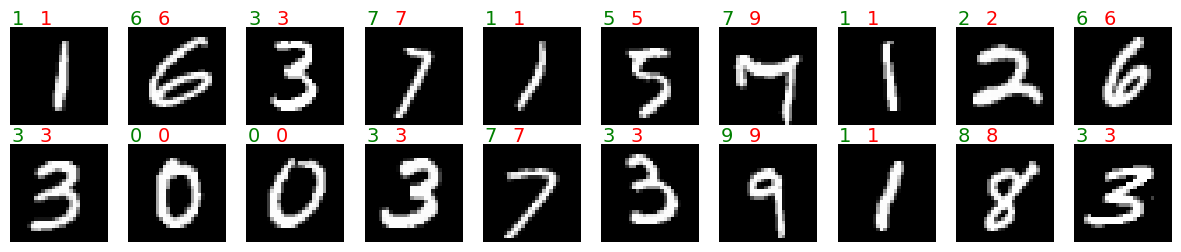

In [24]:
showErrors(model, test_dataloader)

## Additional Challenges

a) As the test accuracy should show, the MNIST dataset is not very challenging, change the code to use Fashion-MNIST and compare the results.

b) Do the same for the CIFAR10 (or CIFAR100) dataset. Note that, in this case, each image is a 32x32 color image; convert it to grayscale or concatenate the RGB channels in one single vector (e.g. using the reshape method).

c) The test accuracy for CIFAR is significantly worse. Try improving the results by using: 1) a deeper architecture, and 2) a different optmizer.

You can load the datasets from [here](https://pytorch.org/vision/stable/datasets.html).
